# Вступление

Доброго дня! Меня зовут Васюхин Артём и это проект для компании GoProtect, занимающейся страхованием спортсменов.

**Цель проекта:** создать ML-модель для прогнозирования успешного выполнения элементов на соревнованиях по фигурному катанию.

</p>
</p>
<details >
    <summary style="background-color: lightblue;"><b>ОПИСАНИЕ ДАННЫХ</b></summary>

<b>units</b>

<li>id: идентификатор юнита</li>
<li>color: категория</li>
<li>school\_id: идентификатор школы</li>

<b>tournaments</b>

Турнир состоит из нескольких категорий, оценки по категориям расписаны в total\_scores

<li>id: идентификатор турнира</li>
<li>date\_start: дата начала</li>
<li>date\_end: дата завершения</li>
<li>origin\_id: место проведения</li>

<b>total_scores</b>

Оценки за выступления по категориям и общие за турнир

<li>id: идентификатор выступления, джойнится с tournament\_scores.total\_score\_id</li>
<li>unit\_id: идентификатор юнита, ключ к units.id</li>
<li>tournament\_id: идентификатор турнира, tournaments.id</li>
<li>components\_score: артистизм (мастерство, композиция, хореография)</li>
<li>base\_score: базовая оценка за элементы в выступлении (идеал)</li>
<li>elements\_score: реальная оценка всех выполненных элементов, base\_score+goe</li>
<li>decreasings\_score: снижения оценок за ошибки</li>
<li>total\_score: components\_score+elements\_score+decreasings\_score за выступление</li>
<li>starting\_place:
<li>place: занятое место в категории category\_name+segment\_name</li>
<li>segment\_name: название сегмента</li>
<li>info: комментарии и пояснения к оценке</li>
<li>overall\_place: итоговое место в турнире</li>
<li>overall\_total\_score: итоговая оценка за весь турнир</li>
<li>overall\_place\_str: комментарии, пояснения</li>

<b>tournament\_scores</b>

Таблица с оценками поэлементно

<li>id: идентификатор оценки за конкретный элемент/комбинацию</li>
<li>total\_score\_id: идентикатор выступления, ключ total\_scores.id</li>
<li>title: запись элемента или комбинации элементов с отметками об ошибках</li>
<li>decrease: за что снижена оценка</li>
<li>base\_score: базовая оценка (идеал, цена данного элемента/комбинации, сложность)</li>
<li>goe: Grade of Execute, качество исполнения, судейские надбавки/убавки</li>
<li>avg\_score: оценка за элемент/комбинацию (усредненная по судьям)</li>

Расшифровка элементов tournaments\_scores.title

Разбираем только одиночное катание. Есть 3 типа элементов:

- Прыжки: начинаются с цифры от 1 до 4, потом идет код прыжка, потом может стоять один из специальных кодов
- Вращения. Сначала идет код вращения, после которого стоит уровень (B – базовый, 1, 2, 3,
  - Если после элемента стоит NV – not value значит элемент не выполнен.
- Шаги. Два варианта. Может быть так же как у вращений 5 уровней и NV – StSqB, StSq1 и тд.
- Внимание:
  - Могут попадаться базовые уровни без литеры В, например ChSt или CCoSp
  - Иногда прыжки иногда указаны без цифры
  - Также могут встречаться отдельные элементы из других групп
- Ошибки:
  - q – недокрут прыжка в четверть оборота. Базовая стоимость при такой ошибке остается неизменной, но судьи обязательно снизят за это GOE
  - < – спортсмен провращался в воздухе на 90°-180 ° меньше, чем положено, "недокрутил". Стоимость прыжка за такую ошибку не сильно, но снижают.
  - << – спортсмен недокрутил более 180°. Стоимость прыжка становится, как если бы прыгнул на один оборот меньше
  - e – Этот знак ставится, когда фигурист отталкивается от льда с неправильного ребра. Правильные ребра: на лутце – наружное, на флипе – внутреннее. На базовую стоимость влияет ровно на то же количество баллов, что и <
  - ! – Этот знак так же ставится только у флипа и лутца в случае, если технический специалист посчитал, что отрыв происходит с "нечеткого ребра". На базовую стоимость прыжка эта ошибка не влияет, но судьи обязательно её учтут при выставлении GOE
  - COMBO – Не выполнен обязательный каскад в короткой программе. Этот знак после прыжка, например: 3Lz+COMBO, говорит о том, что спортсмен должен был исполнить каскад прыжков, но, по какой-то причине (чаще всего падение), не смог. На оценку не влияет, но оставляет плохое впечатление у судейской бригады.
  - REP – Обозначает ошибку, похожую на COMBO, но в произвольной программе. По правилам, в произвольной программе фигурного катания один и тот же прыжок второй раз можно исполнить только в составе каскада или комбинации. Если по каким то причинам спортсмен оба раза прыгнул прыжок сольно, то ко второй попытке добавляют этот знак и базовую стоимость уменьшают на 30%.
  - SEQ – Комбинация прыжков. Фигурист сразу после любого прыжка делает аксель. В этом случае SEQ означает, что была исполнена комбинация прыжков. Раньше базовая стоимость прыжков, исполненных в комбинации, умножалась на коэффицент 0.8, с сезона 2022 стоимость комбинации приравнивается к каскаду
- Бонус:

○ x – Элемент исполнен во второй половине программы. Отностится только к прыжкам! Если прыжок сделан во второй половине программы, его базовая стоимость умножается на коэффициент 1.1. Недавно введено ограничение – только три последних прыжка получат бонус. Ввели это ограничение, потому что многие спортсмены переносили все свои прыжки во вторую часть.

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libs" data-toc-modified-id="Libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libs</a></span></li><li><span><a href="#Settings" data-toc-modified-id="Settings-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Settings</a></span></li><li><span><a href="#Constants" data-toc-modified-id="Constants-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Constants</a></span></li><li><span><a href="#Data-import" data-toc-modified-id="Data-import-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data import</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#NaN" data-toc-modified-id="NaN-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>NaN</a></span><ul class="toc-item"><li><span><a href="#total_scores" data-toc-modified-id="total_scores-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>total_scores</a></span></li><li><span><a href="#tournament_scores" data-toc-modified-id="tournament_scores-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>tournament_scores</a></span></li></ul></li><li><span><a href="#Values-(numerical)" data-toc-modified-id="Values-(numerical)-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Values (numerical)</a></span><ul class="toc-item"><li><span><a href="#total_scores" data-toc-modified-id="total_scores-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>total_scores</a></span></li><li><span><a href="#tournament_scores" data-toc-modified-id="tournament_scores-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>tournament_scores</a></span><ul class="toc-item"><li><span><a href="#base_score,-goe,-avg_score" data-toc-modified-id="base_score,-goe,-avg_score-5.2.2.1"><span class="toc-item-num">5.2.2.1&nbsp;&nbsp;</span>base_score, goe, avg_score</a></span></li></ul></li></ul></li><li><span><a href="#Values-(categorical)" data-toc-modified-id="Values-(categorical)-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Values (categorical)</a></span><ul class="toc-item"><li><span><a href="#total_scores" data-toc-modified-id="total_scores-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>total_scores</a></span><ul class="toc-item"><li><span><a href="#segment_name" data-toc-modified-id="segment_name-5.3.1.1"><span class="toc-item-num">5.3.1.1&nbsp;&nbsp;</span>segment_name</a></span></li><li><span><a href="#info" data-toc-modified-id="info-5.3.1.2"><span class="toc-item-num">5.3.1.2&nbsp;&nbsp;</span>info</a></span></li></ul></li><li><span><a href="#tournament_scores" data-toc-modified-id="tournament_scores-5.3.2"><span class="toc-item-num">5.3.2&nbsp;&nbsp;</span>tournament_scores</a></span><ul class="toc-item"><li><span><a href="#decrease" data-toc-modified-id="decrease-5.3.2.1"><span class="toc-item-num">5.3.2.1&nbsp;&nbsp;</span>decrease</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Объединение-датасетов" data-toc-modified-id="Объединение-датасетов-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Объединение датасетов</a></span><ul class="toc-item"><li><span><a href="#Корреляция" data-toc-modified-id="Корреляция-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Корреляция</a></span><ul class="toc-item"><li><span><a href="#Выводы-по-коррелляции" data-toc-modified-id="Выводы-по-коррелляции-6.1.1"><span class="toc-item-num">6.1.1&nbsp;&nbsp;</span>Выводы по коррелляции</a></span></li></ul></li></ul></li><li><span><a href="#Подготовка-данных-к-моделированию" data-toc-modified-id="Подготовка-данных-к-моделированию-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Подготовка данных к моделированию</a></span><ul class="toc-item"><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Разделение на выборки</a></span></li><li><span><a href="#Кодирование" data-toc-modified-id="Кодирование-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Кодирование</a></span></li></ul></li><li><span><a href="#Моделирование" data-toc-modified-id="Моделирование-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Моделирование</a></span><ul class="toc-item"><li><span><a href="#dummy" data-toc-modified-id="dummy-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>dummy</a></span></li><li><span><a href="#CBR" data-toc-modified-id="CBR-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>CBR</a></span><ul class="toc-item"><li><span><a href="#valid_sample" data-toc-modified-id="valid_sample-8.2.1"><span class="toc-item-num">8.2.1&nbsp;&nbsp;</span>valid_sample</a></span></li><li><span><a href="#test_sample" data-toc-modified-id="test_sample-8.2.2"><span class="toc-item-num">8.2.2&nbsp;&nbsp;</span>test_sample</a></span></li></ul></li><li><span><a href="#Вывод-по-построению-моделей" data-toc-modified-id="Вывод-по-построению-моделей-8.3"><span class="toc-item-num">8.3&nbsp;&nbsp;</span>Вывод по построению моделей</a></span></li></ul></li><li><span><a href="#Вывод-по-проекту" data-toc-modified-id="Вывод-по-проекту-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Вывод по проекту</a></span></li></ul></div>

## Libs ##

In [1]:
 # pip freeze > requirements.txt

In [2]:
# импортируем файл requirments

# pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

import os
import re
from os.path import isfile, join
import tqdm
from tqdm import tqdm

import joblib
import json

from itertools import chain

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor

In [4]:
import phik

In [5]:
import xgboost as xgb
from catboost import CatBoostRegressor

## Settings ##

In [6]:
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.colheader_justify = 'left'

tqdm.pandas()

## Constants

In [7]:
PATH = 'data'

RANDOMSTATE = SEED = 69

VALID_FRAC = 0.2                                                      # валидационная выборка выделяется из всех данных
TEST_FRAC = 0.5                                                       # тестовая выборка выделяется из валидационной

## Data import ##

In [8]:
os.listdir(PATH)

['total_scores.csv', 'tournaments.csv', 'tournament_scores.csv', 'units.csv']

In [9]:
files = os.listdir(PATH)

# функция распаковки
def csv_reader(file):
    data = pd.read_csv(f'{PATH}/{file}'.format())
    return data

In [10]:
# импорт данных
df_total_scores = csv_reader(files[0])
df_tournaments = csv_reader(files[1])
df_tournament_scores = csv_reader(files[2])
df_units = csv_reader(files[3])

In [11]:
display(df_total_scores.info())
display(df_total_scores.head(3))
print('-'*100)
display(df_tournaments.info())
display(df_tournaments.head(3))
print('-'*100)
display(df_tournament_scores.info())
display(df_tournament_scores.head(3))
print('-'*100)
display(df_units.info())
display(df_units.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6), int64(6), object(3)
m

None

,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
0,442027,304,4785,47.200,43.470,102.700,59.230,0.000,17,1,Короткая программа,x Надбавка за прыжки во второй половине программы (10%),2,293.740,2
1,442028,604,4785,45.400,46.710,101.190,54.480,0.000,18,2,Короткая программа,q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%),1,294.750,1
2,442029,409,4785,44.000,46.820,99.200,52.380,0.000,6,3,Короткая программа,q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%),4,285.570,4


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          142 non-null    int64  
 1   date_start  142 non-null    object 
 2   date_end    142 non-null    object 
 3   origin_id   142 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ KB


None

,id,date_start,date_end,origin_id
0,1,2090-11-29,2090-12-01,2.000
1,2,2091-03-06,2091-03-10,1.000
2,3,2090-10-05,2090-10-08,2.000


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ MB


None

,id,total_score_id,title,decrease,base_score,goe,avg_score
0,1,1,2A,NaN,3.300,0.660,3.960
1,2,1,3F+3Lo,NaN,10.200,-0.110,10.090
2,3,1,3Lz,NaN,0.000,-1.300,5.190


----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4596 entries, 0 to 4595
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4596 non-null   int64  
 1   color      4595 non-null   object 
 2   school_id  4007 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 107.8+ KB


None

,id,color,school_id
0,9474,green,244.000
1,733,green,203.000
2,734,green,235.000


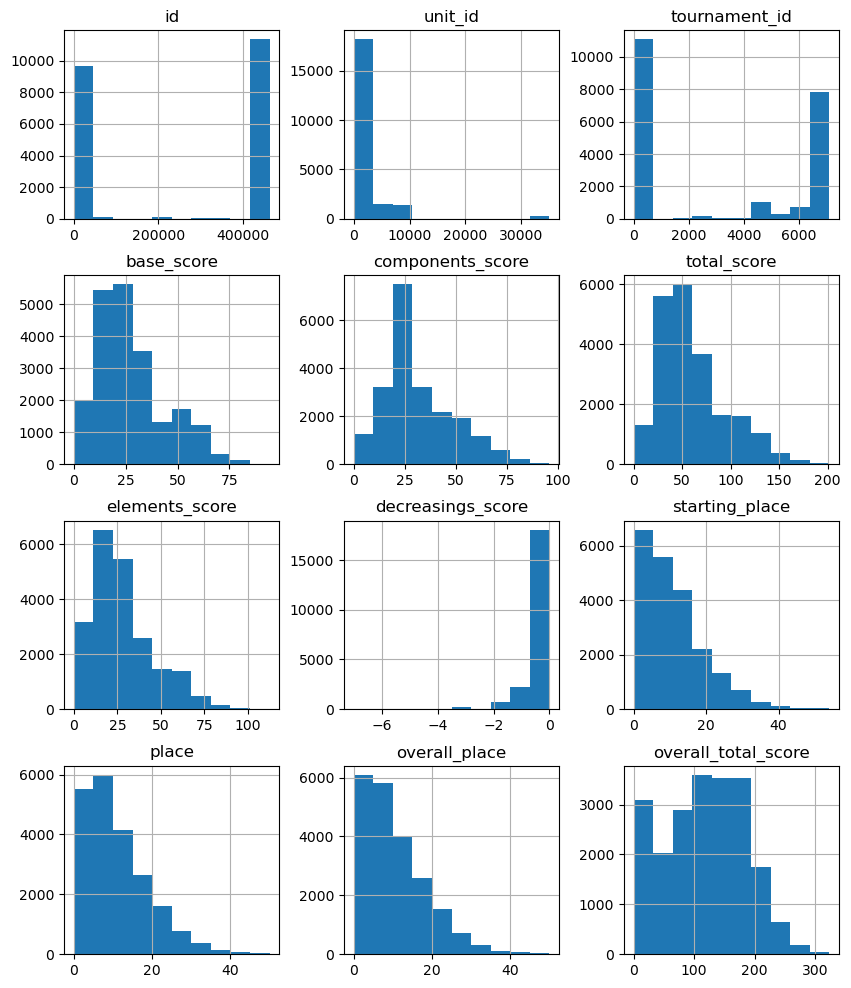

In [12]:
df_total_scores.hist(figsize=(10, 12));

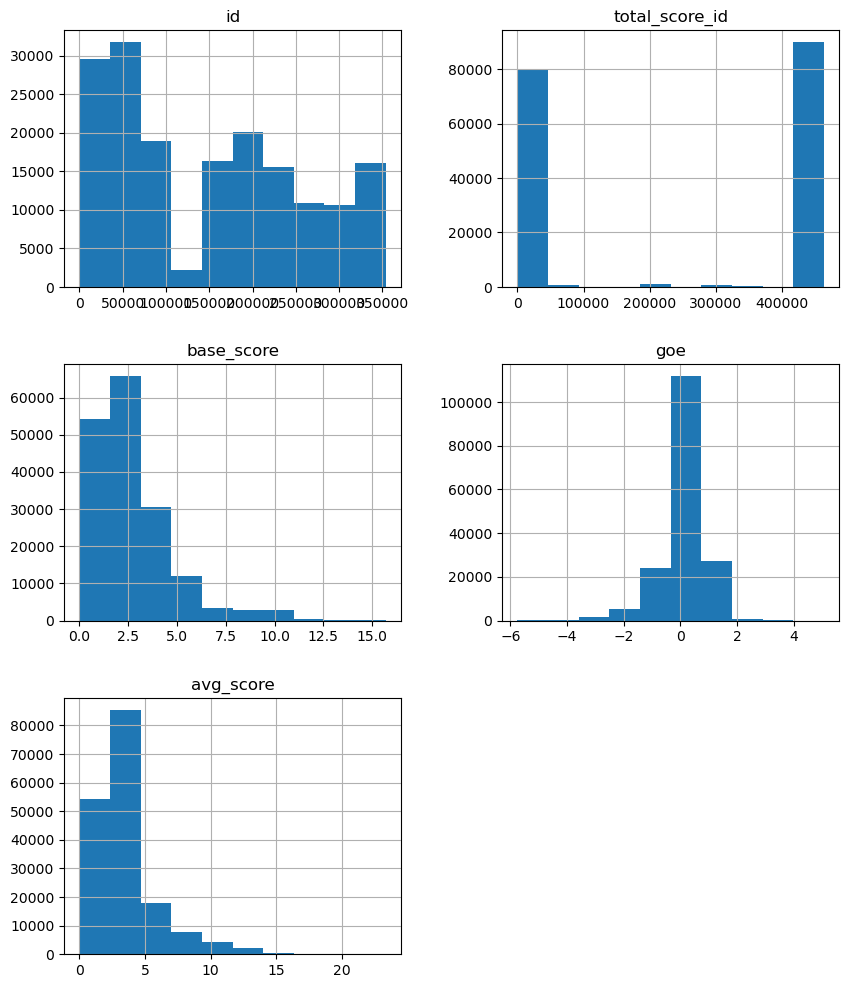

In [13]:
df_tournament_scores.hist(figsize=(10, 12));

> В большинстве колонок у нас вполне адекватные распределения без сверх аномалий.

## EDA ##

In [14]:
# функция анализа датафрейма и его колонок 
def data_info(data, col):
    if col == None:
        display(data.info())
        display(data.isna().sum())
        display(data.head())
    else:
        display(data[col].value_counts().sort_values(ascending=False).head(10))
        print('='*80)
        print(data[col].unique())
        print('='*80)
        print(f'Количество пропусков: {data[col].isna().sum()} ({((data[col].isna().sum() / len(data[col])) * 100).round(2)}%)'.format()
             )
        display(data[data[col].isna()])

### NaN ###

#### total_scores ####

In [15]:
data_info(df_total_scores, None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21301 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21301 non-null  int64  
 1   unit_id              21301 non-null  int64  
 2   tournament_id        21301 non-null  int64  
 3   base_score           21301 non-null  float64
 4   components_score     21301 non-null  float64
 5   total_score          21301 non-null  float64
 6   elements_score       21301 non-null  float64
 7   decreasings_score    21301 non-null  float64
 8   starting_place       21301 non-null  int64  
 9   place                21301 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21301 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6), int64(6), object(3)
m

None

id                         0
unit_id                    0
tournament_id              0
base_score                 0
components_score           0
total_score                0
elements_score             0
decreasings_score          0
starting_place             0
place                      0
segment_name              17
info                     581
overall_place              0
overall_total_score       17
overall_place_str      10487
dtype: int64

,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
0,442027,304,4785,47.200,43.470,102.700,59.230,0.000,17,1,Короткая программа,x Надбавка за прыжки во второй половине программы (10%),2,293.740,2
1,442028,604,4785,45.400,46.710,101.190,54.480,0.000,18,2,Короткая программа,q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%),1,294.750,1
2,442029,409,4785,44.000,46.820,99.200,52.380,0.000,6,3,Короткая программа,q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%),4,285.570,4
3,442030,524,4785,46.200,44.860,91.840,47.980,-1.000,3,4,Короткая программа,q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%) F Падение ...,3,292.420,3
4,442031,412,4785,44.200,42.590,89.730,48.140,-1.000,15,5,Короткая программа,q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%) F Падение ...,6,265.340,6


In [16]:
df_total_scores.sort_values('id').head(3)

,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
9028,1,1,1,31.990,24.670,56.860,33.190,0.000,2,5,Короткая программа,x Надбавка за прыжки во второй половине программы (10%),4,164.440,NaN
9020,8,1,1,57.300,49.400,107.580,58.180,0.000,2,4,Произвольная программа,q Прыжок приземлён в четверть < Недокрученный прыжок x Надбавка за прыжки во второй половине про...,4,164.440,NaN
18546,19,1426,1,32.010,28.660,67.350,38.690,0.000,4,1,Короткая программа,x Надбавка за прыжки во второй половине программы (10%),1,201.450,NaN


In [17]:
# проверим на совпадение прпоуски в segment_name и overall_total_score
x = (df_total_scores[df_total_scores['segment_name'].isna()].index)
y = (df_total_scores[df_total_scores['overall_total_score'].isna()].index)
x == y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [18]:
# удаляем пропуски
df_total_scores.dropna(subset=['segment_name', 'overall_total_score'], inplace=True)

In [19]:
df_total_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21284 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   21284 non-null  int64  
 1   unit_id              21284 non-null  int64  
 2   tournament_id        21284 non-null  int64  
 3   base_score           21284 non-null  float64
 4   components_score     21284 non-null  float64
 5   total_score          21284 non-null  float64
 6   elements_score       21284 non-null  float64
 7   decreasings_score    21284 non-null  float64
 8   starting_place       21284 non-null  int64  
 9   place                21284 non-null  int64  
 10  segment_name         21284 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        21284 non-null  int64  
 13  overall_total_score  21284 non-null  float64
 14  overall_place_str    10814 non-null  object 
dtypes: float64(6), int64(6), object(3)
memory

>После проврки пропусков было установлено, что принципиально они ни на что не влияют, их мало и никакой конкретики там нет. Поэтому заполним значения в **overall_place_str** по **overall_place**, а пропуски в **info** просто удалим.

In [20]:
# заполним по значению overall_place
df_total_scores['overall_place_str'] = df_total_scores['overall_place_str'].fillna(df_total_scores['overall_place'])

df_total_scores.dropna(subset=['info'], inplace=True)

In [21]:
# проверим Nan
df_total_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20720 entries, 0 to 21300
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   20720 non-null  int64  
 1   unit_id              20720 non-null  int64  
 2   tournament_id        20720 non-null  int64  
 3   base_score           20720 non-null  float64
 4   components_score     20720 non-null  float64
 5   total_score          20720 non-null  float64
 6   elements_score       20720 non-null  float64
 7   decreasings_score    20720 non-null  float64
 8   starting_place       20720 non-null  int64  
 9   place                20720 non-null  int64  
 10  segment_name         20720 non-null  object 
 11  info                 20720 non-null  object 
 12  overall_place        20720 non-null  int64  
 13  overall_total_score  20720 non-null  float64
 14  overall_place_str    20720 non-null  object 
dtypes: float64(6), int64(6), object(3)
memory

#### tournament_scores ####

In [22]:
data_info(df_tournament_scores, None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              172158 non-null  int64  
 1   total_score_id  172158 non-null  int64  
 2   title           172158 non-null  object 
 3   decrease        41185 non-null   object 
 4   base_score      172158 non-null  float64
 5   goe             172158 non-null  float64
 6   avg_score       172158 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 9.2+ MB


None

id                     0
total_score_id         0
title                  0
decrease          130973
base_score             0
goe                    0
avg_score              0
dtype: int64

,id,total_score_id,title,decrease,base_score,goe,avg_score
0,1,1,2A,NaN,3.300,0.660,3.960
1,2,1,3F+3Lo,NaN,10.200,-0.110,10.090
2,3,1,3Lz,NaN,0.000,-1.300,5.190
3,4,1,CCoSp4,NaN,3.500,0.560,4.060
4,5,1,FCSp4,NaN,3.200,0.640,3.840


In [23]:
df_tournament_scores[df_tournament_scores['decrease'].notna()].sample(10)

,id,total_score_id,title,decrease,base_score,goe,avg_score
15303,19263,5524,3F!+2T,!,6.600,0.180,6.780
132245,220930,449540,2Lz!<<+1A+SЕQ,<<,1.700,-0.550,1.150
155018,288479,455801,2Lo<+1A+SЕQ,<,2.460,-0.270,2.190
129881,217635,449093,1F+1Lo<,F,0.900,-0.250,0.650
13347,16589,5183,3Lz,F,5.900,-2.950,2.950
881,882,875,CCoSp3V,nC,2.250,0.000,2.250
125528,213228,448499,2A<<,<<,1.100,-0.550,0.550
21655,26220,6367,2A*+2T*,*,0.000,0.000,0.000
105744,199535,446755,3F+3T<,<,8.660,-0.710,7.950
132314,220999,449549,2Lz+2Loq,q,0.000,-0.210,3.970


In [24]:
df_tournament_scores[df_tournament_scores['decrease'].isna()].sample(10)

,id,total_score_id,title,decrease,base_score,goe,avg_score
120791,161281,442683,CSSp4,NaN,3.000,0.480,3.480
85343,160397,442554,StSqB,NaN,1.500,0.000,1.500
109837,183576,444758,3Lo,NaN,4.900,0.980,5.880
159096,344146,462388,2S,NaN,1.300,0.130,1.430
142857,339070,461710,LSp3,NaN,2.400,0.000,2.400
14257,17788,5324,CCoSp4,NaN,3.500,0.980,4.480
83356,95198,29736,2A+1Eu+2F,NaN,0.000,0.400,6.560
162524,307664,458216,2A,NaN,3.300,0.660,3.960
29744,35425,7572,FCSp3,NaN,2.800,0.730,3.530
19276,23841,6060,2A,NaN,3.300,0.660,3.960


>Видно, что у некоторых элементов имеется сниженная оценка, однако строка в **decrease** пустая. Проверим сколько таких элементов.

In [25]:
df_tournament_scores[(df_tournament_scores['decrease'].isna()) & (df_tournament_scores['goe'] < 0)]

,id,total_score_id,title,decrease,base_score,goe,avg_score
1,2,1,3F+3Lo,NaN,10.200,-0.110,10.090
2,3,1,3Lz,NaN,0.000,-1.300,5.190
38,39,38,3F,NaN,0.000,-0.110,5.720
46,47,45,3Lo+2A+2T+SЕQ,NaN,0.000,-0.780,9.670
65,66,64,3S,NaN,4.300,-1.290,3.010
...,...,...,...,...,...,...,...
172069,351924,463395,2Lo+1A+SЕQ,NaN,2.800,-0.110,2.690
172094,351953,463399,CCoSp1,NaN,2.000,-0.070,1.930
172112,351971,463402,2S+1A+SЕQ,NaN,2.400,-0.090,2.310
172135,351990,463405,2S+1A+SЕQ,NaN,2.400,-0.260,2.140


In [26]:
# посмотрим на колонку info, где собрана сводка по конкретному выступлению
df_total_scores.query('id == [1, 38, 45]')

,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
9019,38,3,1,31.930,25.870,60.750,34.880,0.000,1,3,Короткая программа,x Надбавка за прыжки во второй половине программы (10%),5,161.100,5
9023,45,3,1,51.780,50.460,100.350,49.890,0.000,4,6,Произвольная программа,q Прыжок приземлён в четверть < Недокрученный прыжок << Пониженный прыжок ! Неясное ребро на тол...,5,161.100,5
9028,1,1,1,31.990,24.670,56.860,33.190,0.000,2,5,Короткая программа,x Надбавка за прыжки во второй половине программы (10%),4,164.440,4


>Как мы видим из примера выше, конкретные ошибки прописаны не везде, поэтому заменить эти пропуски на что-то вменяемое мы не можем, поэтому оставляем как есть.

### Values (numerical) ###

#### total_scores ####

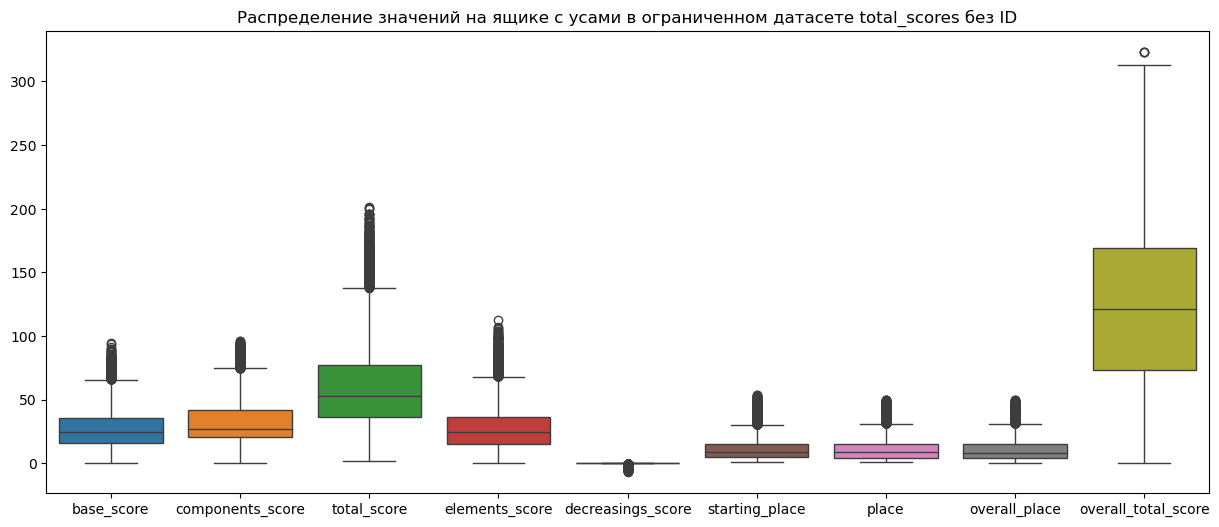

In [27]:
df = df_total_scores.iloc[:, 3:]

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df)
plt.title('Распределение значений на ящике с усами в ограниченном датасете total_scores без ID')
plt.show();

>Мы видим равномерность выбросов для всех численных колонок, а нормальное распределение в **overall_total_score** говорит нам о корректности всех остальных значений. **Starting_place, place и overall_place** зависят от числа участников.

#### tournament_scores ####

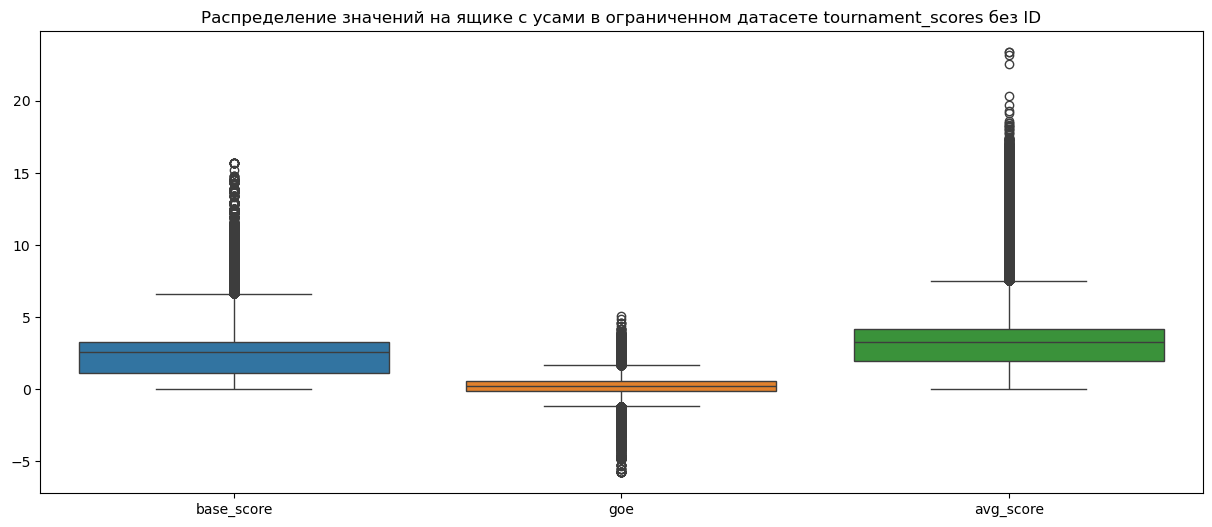

In [28]:
df = df_tournament_scores.iloc[:, 2:]

fig, ax = plt.subplots(figsize=(15, 6))
sns.boxplot(data=df)
plt.title('Распределение значений на ящике с усами в ограниченном датасете tournament_scores без ID')
plt.show();

In [29]:
df.query('avg_score > 15')

,title,decrease,base_score,goe,avg_score
3918,3A+1Eu+3S,NaN,12.800,2.400,15.200
4464,3Lz+3T+2A,NaN,0.000,1.300,16.040
5074,4T+3T,NaN,13.700,3.610,17.310
5082,4T+3T,NaN,13.700,2.850,16.550
5088,4T+3T,B,13.700,2.850,16.550
5103,4T+3T,NaN,13.700,2.660,16.360
5201,4T+3T,NaN,13.700,3.040,16.740
5213,4S+3T,NaN,13.900,2.910,16.810
5215,4T+2A,NaN,12.800,2.470,15.270
5249,4T+3T,NaN,13.700,3.040,16.740


>Ситуация аналогичная: основной колонкой является **avg_score**, где все значения, выходящие за 4 квартиль, получены в результате исполнения "дорогих" прыжков и комбинаций из них. 
Также можно наблюдать нулевые значения в колонке **base_score**, которые иы заменим на разность **avg_score и goe**. 
Помимо этого у нас есть категоря **B**, которая означает бонус и не совсем корректно подходит в данную колонку, однако далее мы разобьем все категории с бинарной классификацией внутри и поэтому в данном случае **B** нам не мешает.

##### base_score, goe, avg_score #####

>Разберемся сначала с нулями в **base_score**

In [30]:
df_tournament_scores[df_tournament_scores['base_score'] == 0]

,id,total_score_id,title,decrease,base_score,goe,avg_score
2,3,1,3Lz,NaN,0.000,-1.300,5.190
8,9,8,3F,NaN,0.000,0.420,6.250
11,12,8,3Lzq+2T,q,0.000,-0.470,7.450
12,13,8,3S,NaN,0.000,0.430,5.160
20,21,19,3Lz+3T,NaN,0.000,1.530,12.640
...,...,...,...,...,...,...,...
171955,322970,460276,2Lz+1A+SЕQ,NaN,0.000,0.140,3.660
171956,322971,460276,2F+2Lo,NaN,0.000,0.240,4.090
172028,351883,463389,2F<<*,<<*,0.000,0.000,0.000
172101,351960,463400,1F*,*,0.000,0.000,0.000


In [31]:
# заменяем нулевые значения в base_score на разность avg_score и goe
df_tournament_scores.loc[df_tournament_scores['base_score'] == 0, 'base_score'] = (
    df_tournament_scores['avg_score'] - df_tournament_scores['goe'])[df_tournament_scores['base_score'] == 0].values

In [32]:
df_tournament_scores[df_tournament_scores['base_score'] == 0]

,id,total_score_id,title,decrease,base_score,goe,avg_score
180,181,181,1Lo*,*,0.000,0.000,0.000
187,188,188,1A<<,<<,0.000,0.000,0.000
237,238,233,FCSp,NaN,0.000,0.000,0.000
282,283,274,S,F,0.000,0.000,0.000
622,623,619,FCSp,NaN,0.000,0.000,0.000
...,...,...,...,...,...,...,...
171874,323003,460280,2Lz<*,F,0.000,0.000,0.000
171875,323004,460280,Sp*,F,0.000,0.000,0.000
172028,351883,463389,2F<<*,<<*,0.000,0.000,0.000
172101,351960,463400,1F*,*,0.000,0.000,0.000


>У нас осталось четыре тысячи строк, где все значения **base_score, goe и avg_score** имеют нулевые значения. Помимо этого видно, что много где есть падения. Предположим, что из-за падения оценка за элемент полностью убирается. Проверим гипотезу:

**H0: у всех элементов, где есть падение (F), отсутствует оценка**

**H1: не у всех элементов, где есть падение (F), отсутствует оценка**

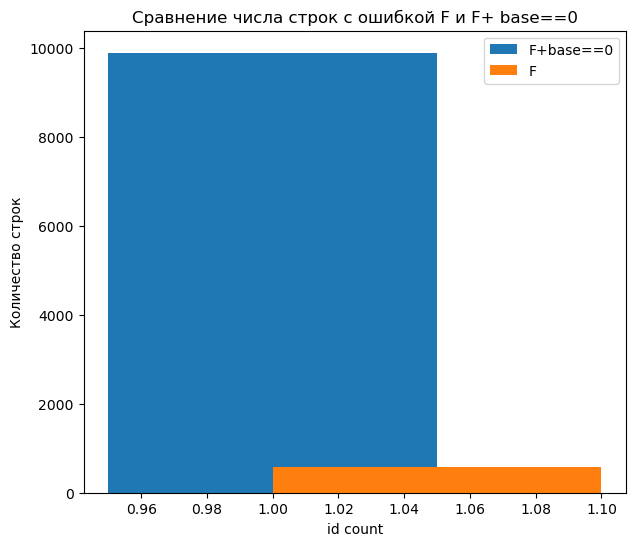

In [33]:
# создадим два отдельных фрейма со всеми F и F+0 в base_score
x = df_tournament_scores[df_tournament_scores['decrease'] == 'F']
y = df_tournament_scores[(df_tournament_scores['decrease'] == 'F')&(df_tournament_scores['base_score'] == 0)]

count_x = x['id'].count()
count_y = y['id'].count()

# Построение графика
#labels = x.columns
#num_labels = range(len(0, 1))

fig, ax = plt.subplots(figsize=(7, 6))
ax.bar((1, 1), count_x, width=0.1, label='F+base==0', align='center')
ax.bar((1, 1), count_y, width=0.1,label='F', align='edge')
ax.set_xlabel('id count')
ax.set_ylabel('Количество строк')
ax.set_title('Сравнение числа строк с ошибкой F и F+ base==0')
ax.legend()
plt.show()

>**Нулевая гипотеза** отвергается: не у всех элементов, где оценка F, отсутствует базовый скор. Соответственно, 4000 строк имеют иную природу нулей в **base_score** и будут удалены, так как принципиальной конкретики в них нет.

In [34]:
index_to_drop_decrease = df_tournament_scores[df_tournament_scores['base_score'] == 0].index
df_tournament_scores = df_tournament_scores.drop(index_to_drop_decrease)

In [35]:
df_tournament_scores

,id,total_score_id,title,decrease,base_score,goe,avg_score
0,1,1,2A,NaN,3.300,0.660,3.960
1,2,1,3F+3Lo,NaN,10.200,-0.110,10.090
2,3,1,3Lz,NaN,6.490,-1.300,5.190
3,4,1,CCoSp4,NaN,3.500,0.560,4.060
4,5,1,FCSp4,NaN,3.200,0.640,3.840
...,...,...,...,...,...,...,...
172153,352008,463407,CCoSp3,NaN,3.000,0.600,3.600
172154,352009,463407,2Lz,NaN,2.100,0.000,2.100
172155,352010,463407,2Lo,NaN,1.700,0.230,1.930
172156,352011,463407,StSq2,NaN,2.600,0.520,3.120


>Учитывая имеющиеся данные и поставленную задачу, при помощи **avg_score** и **base_score** мы можем найти отношение (ratio) этих двух величин и выделить их в наш ***таргет***, который будет наглядно показывать успешность или не успешность выполнения каждого отдельно взятого элемента в программе.

>Сравним распределение ratio при *avg_score / base_score* и *avg_score / base_score - 1*.

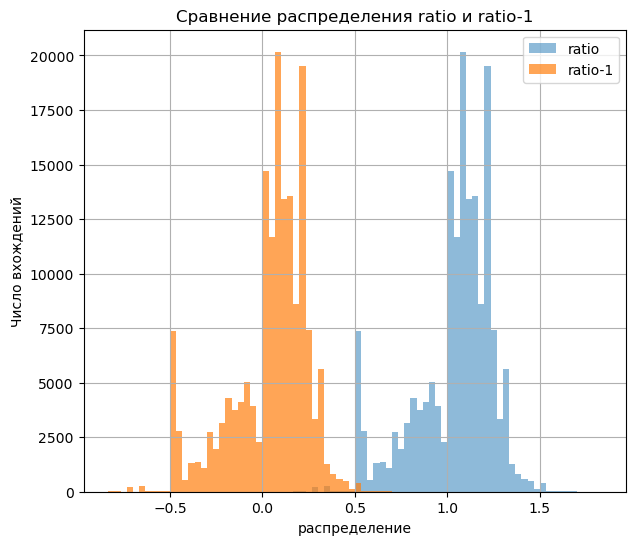

In [36]:
df_tournament_scores['ratio'] = df_tournament_scores['avg_score'] / df_tournament_scores['base_score']
df_tournament_scores['ratio-1'] = (df_tournament_scores['avg_score'] / df_tournament_scores['base_score']) - 1

fig, ax = plt.subplots(figsize=(7, 6))
ax.hist(df_tournament_scores['ratio'], alpha=0.5, label='ratio', bins=50)
ax.hist(df_tournament_scores['ratio-1'], alpha=0.7, label='ratio-1', bins=50)
ax.grid(True)
ax.set_xlabel('распределение')
ax.set_ylabel('Число вхождений')
ax.set_title('Сравнение распределения ratio и ratio-1')
ax.legend()
plt.show()

>Как можно заметить, **ratio-1** имеет околонулевое распределение, делая таким образом наш таргет более качественным. Попробуем отмести крайние квартили.

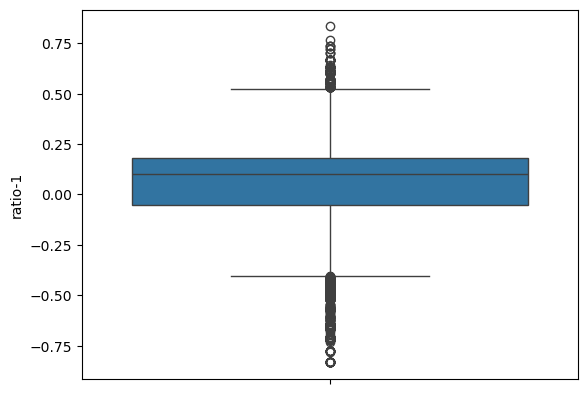

In [37]:
sns.boxplot(df_tournament_scores['ratio-1']);

In [38]:
def lower_upper_bound(df, col):
    
    q1 = df[col].quantile(.25)
    q3 = df[col].quantile(.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    cropped_df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return cropped_df[col]

cropped_ratio = lower_upper_bound(df_tournament_scores, 'ratio-1')

In [39]:
q1 = df_tournament_scores['ratio-1'].quantile(.25)
q3 = df_tournament_scores['ratio-1'].quantile(.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_tournament_scores.query('ratio-1 >= @lower_bound & ratio-1 <= @upper_bound')

,id,total_score_id,title,decrease,base_score,goe,avg_score,ratio,ratio-1
0,1,1,2A,NaN,3.300,0.660,3.960,1.200,0.200
1,2,1,3F+3Lo,NaN,10.200,-0.110,10.090,0.989,-0.011
2,3,1,3Lz,NaN,6.490,-1.300,5.190,0.800,-0.200
3,4,1,CCoSp4,NaN,3.500,0.560,4.060,1.160,0.160
4,5,1,FCSp4,NaN,3.200,0.640,3.840,1.200,0.200
...,...,...,...,...,...,...,...,...,...
172153,352008,463407,CCoSp3,NaN,3.000,0.600,3.600,1.200,0.200
172154,352009,463407,2Lz,NaN,2.100,0.000,2.100,1.000,0.000
172155,352010,463407,2Lo,NaN,1.700,0.230,1.930,1.135,0.135
172156,352011,463407,StSq2,NaN,2.600,0.520,3.120,1.200,0.200


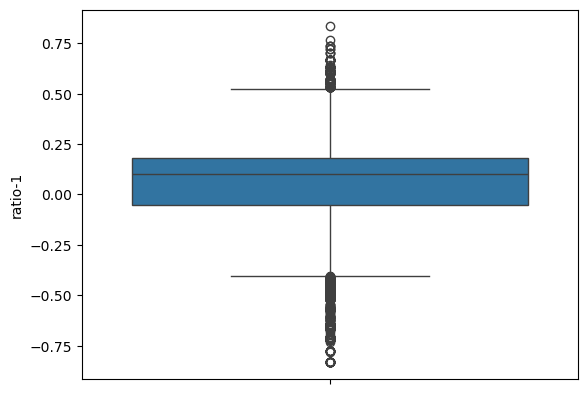

In [40]:
sns.boxplot(df_tournament_scores['ratio-1'],);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


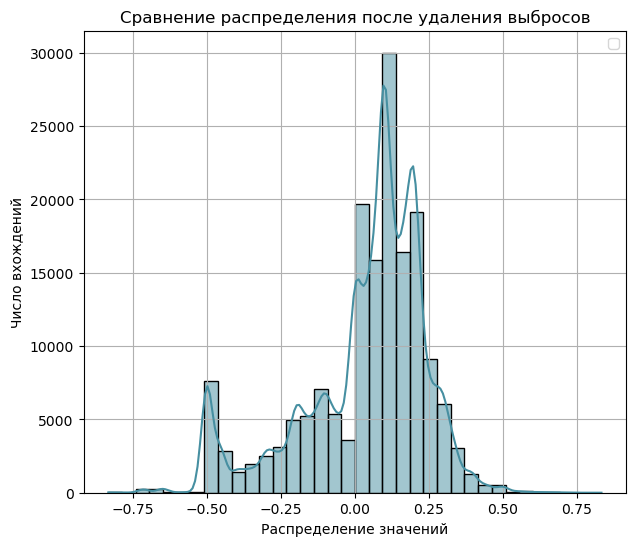

In [41]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.histplot(df_tournament_scores['ratio-1'], 
             kde=True, 
             bins=int(180/5), 
             color = '#468FA1'
            )
ax.grid(True)
ax.set_xlabel('Распределение значений')
ax.set_ylabel('Число вхождений')
ax.set_title('Сравнение распределения после удаления выбросов')
ax.legend()
plt.show()

>По итогу мы получили практически нормальное распределение и **таргет** для нашей модели.

### Values (categorical) ###

#### total_scores ####

##### segment_name #####

In [42]:
data_info(df_total_scores, 'segment_name')

segment_name
Произвольная программа     9290
Короткая программа         7705
Произвольная программа.    2258
Элементы                    601
Прыжки                      254
Пpoизвoльнaя пpoгpaммa      159
Кopoткaя пpoгpaммa           98
Кoроткая программа           95
Kopoткaя пpoгpaммa           58
Элeмeнты                     58
Name: count, dtype: int64

['Короткая программа' 'Произвольная программа' 'Произвольная программа.'
 'Элементы' 'Интерпретация' 'Интерпретация.' 'Кoроткая программа'
 'Произвольнaя программа' 'Пpoизвoльнaя пpoгpaммa' 'Кopoткaя пpoгpaммa'
 'Элeмeнты' 'Коpоткая программа' 'Пpoизвольная программа' 'Прыжки'
 'Kopoткaя пpoгpaммa' 'Пpoизвольнaя программа' 'Прoизвольная прoграмма']
Количество пропусков: 0 (0.0%)


,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str


In [43]:
# заменяем неявные дубликаты

# словарь подобных символов
eng_to_rus_dict = {
    'A': 'А', 'B': 'В', 'C': 'С', 'E': 'Е', 'H': 'Н', 
    'K': 'К', 'M': 'М', 'O': 'О', 'P': 'Р', 'T': 'Т', 
    'X': 'Х', 'Y': 'У','a': 'а', 'e': 'е', 'o': 'о', 'p': 'р', 
    'c': 'с', 'y': 'у', 'x': 'х', 'k': 'к', '0': 'o'
}

def clean_segment(description):
    condition = r"[^a-zA-Zа-яА-Я\s]"
    text_lower = description.lower()
    clean = re.sub(condition, ' ', text_lower)
    replacing = ''.join(eng_to_rus_dict.get(char, char) for char in clean)
    text_cleaned = replacing.strip()
    return text_cleaned

In [44]:
df_total_scores['segment_name'] = df_total_scores['segment_name'].apply(clean_segment)

In [45]:
df_total_scores['segment_name'].value_counts()

segment_name
произвольная программа    11825
короткая программа         7974
элементы                    659
прыжки                      254
интерпретация                 8
Name: count, dtype: int64

In [46]:
df_total_scores = df_total_scores.query('segment_name != ["элементы", "прыжки", "интерпретация"]')
df_total_scores['segment_name'].value_counts()

segment_name
произвольная программа    11825
короткая программа         7974
Name: count, dtype: int64

##### info #####

In [47]:
data_info(df_total_scores, 'info')

info
x Надбавка за прыжки во второй половине программы (10%)                                                                              2634
< Недокрученный прыжок x Надбавка за прыжки во второй половине программы (10%)                                                        931
q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%)                                                 830
< Недокрученный прыжок x Надбавка за прыжки во второй половине программы (10%) F Падение в элементе                                   643
q Прыжок приземлён в четверть < Недокрученный прыжок x Надбавка за прыжки во второй половине программы (10%)                          608
! Неясное ребро на толчке F/Lz x Надбавка за прыжки во второй половине программы (10%)                                                586
x Надбавка за прыжки во второй половине программы (10%) F Падение в элементе                                                          544
<< Пониженный прыжок x Надбав

['x Надбавка за прыжки во второй половине программы (10%)'
 'q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%)'
 'q Прыжок приземлён в четверть x Надбавка за прыжки во второй половине программы (10%) F Падение в элементе'
 ... 'Нарушения в костюме:@@@(1 of 3)'
 "* Недопустимый элемент q Прыжок приземлён в четверть < Недокрученный прыжок << Пониженный прыжок F Падение в элементе nU Нет базовой позиции 'стоя'"
 "q Прыжок приземлён в четверть < Недокрученный прыжок ! Неясное ребро на толчке F/Lz x Надбавка за прыжки во второй половине программы (10%) nU Нет базовой позиции 'стоя'"]
Количество пропусков: 0 (0.0%)


,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str


In [48]:
def clean_info(description):
    condition = r'((?:^<<)|[^a-zA-Z!<*]|(?:of))'
    clean = re.sub(condition, ' ', str(description))
    text_cleaned = clean.split()
    return text_cleaned

In [49]:
df_total_scores['info'] = df_total_scores['info'].progress_apply(clean_info)

100%|██████████| 19799/19799 [00:00<00:00, 86818.14it/s]


In [50]:
unique_values_info = set(chain.from_iterable(df_total_scores['info']))
unique_values_info

{'!',
 '*',
 '<',
 '<<',
 'B',
 'D',
 'F',
 'Lz',
 'REP',
 'e',
 'nB',
 'nC',
 'nF',
 'nS',
 'nU',
 'q',
 'x'}

In [51]:
def create_binary_columns(group, unique_values = unique_values_info):
    result = {}
    
    for value in unique_values:
        result[value] = int(any(value in params for params in group['info']))
    return pd.Series(result)

binary_info = df_total_scores.groupby('id').apply(create_binary_columns)
binary_info = binary_info.reset_index()
binary_info

C:\Users\Home\AppData\Local\Temp\ipykernel_25520\1408323493.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  binary_info = df_total_scores.groupby('id').apply(create_binary_columns)


,id,REP,Lz,nF,*,nC,e,nB,!,nS,<,B,D,F,q,<<,nU,x
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,8,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
2,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19794,463635,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1
19795,463636,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
19796,463637,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
19797,463638,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,1


#### tournament_scores ####

In [52]:
df_tournament_scores.head()

,id,total_score_id,title,decrease,base_score,goe,avg_score,ratio,ratio-1
0,1,1,2A,NaN,3.300,0.660,3.960,1.200,0.200
1,2,1,3F+3Lo,NaN,10.200,-0.110,10.090,0.989,-0.011
2,3,1,3Lz,NaN,6.490,-1.300,5.190,0.800,-0.200
3,4,1,CCoSp4,NaN,3.500,0.560,4.060,1.160,0.160
4,5,1,FCSp4,NaN,3.200,0.640,3.840,1.200,0.200


In [53]:
def clean_title(description):
    condition = r'(?!StS|ChS)q\b|[+<*!e]'
    clean = re.sub(condition, ' ', str(description))
    result = clean.split()
    return result

In [54]:
df_tournament_scores['title'] = df_tournament_scores['title'].apply(clean_title)

In [55]:
df_tournament_scores['title'].head(10)

0         [2A]
1    [3F, 3Lo]
2        [3Lz]
3     [CCoSp4]
4      [FCSp4]
5       [LSp4]
6      [StSq2]
7         [2A]
8         [3F]
9    [3F, 3Lo]
Name: title, dtype: object

In [56]:
set(chain.from_iterable(df_tournament_scores['title']))

{'1A',
 '1Eu',
 '1F',
 '1Lo',
 '1Lz',
 '1S',
 '1T',
 '1W',
 '2A',
 '2F',
 '2Lo',
 '2Lz',
 '2S',
 '2T',
 '3A',
 '3F',
 '3Lo',
 '3Lz',
 '3S',
 '3T',
 '4F',
 '4Lo',
 '4Lz',
 '4S',
 '4T',
 'A',
 'CCSp1',
 'CCSp1V',
 'CCSp2',
 'CCSp2V',
 'CCSp3',
 'CCSp3V',
 'CCSp4',
 'CCSpB',
 'CCSpBV',
 'CCoSp1',
 'CCoSp1V',
 'CCoSp2',
 'CCoSp2V',
 'CCoSp3',
 'CCoSp3V',
 'CCoSp4',
 'CCoSp4V',
 'CCoSpB',
 'CCoSpBV',
 'COMBO',
 'CSSp1',
 'CSSp1V',
 'CSSp2',
 'CSSp2V',
 'CSSp3',
 'CSSp3V',
 'CSSp4',
 'CSSp4V',
 'CSSpB',
 'CSSpBV',
 'CSp1',
 'CSp2',
 'CSp3',
 'CSp4',
 'CSpB',
 'ChSpl1',
 'ChSq1',
 'CoSp1',
 'CoSp1V',
 'CoSp2',
 'CoSp2V',
 'CoSpB',
 'CoSpBV',
 'FCCSp4',
 'FCCoSp1',
 'FCCoSp1V',
 'FCCoSp2',
 'FCCoSp2V',
 'FCCoSp3',
 'FCCoSp3V',
 'FCCoSp4',
 'FCCoSp4V',
 'FCCoSpB',
 'FCCoSpBV',
 'FCSSp1',
 'FCSSp1V',
 'FCSSp2',
 'FCSSp2V',
 'FCSSp3',
 'FCSSp3V',
 'FCSSp4',
 'FCSSpB',
 'FCSSpBV',
 'FCSp1',
 'FCSp1V',
 'FCSp2',
 'FCSp3',
 'FCSp4',
 'FCSpB',
 'FCoSp2V',
 'FLSp2',
 'FLSp3',
 'FLSp4',
 'FSSp1',
 'FSS

>Согласно описанию данных, в некоторых строках пропущено число оборотов или базовый уровень без литеры. Выше в полученном списке мы видим прыжки и спины. Заменим их на базовые.

In [57]:
def skipped_numbers(row):
    result = []
    for i in row:
        if i in ['F', 'A', 'S', 'T', 'Lo', 'Lz']:
            result.append(f'1{i}')
        elif i in ['CCSp', 'CCoSp', 'CSSp', 'CSp', 
                   'ChS', 'CoSp', 'FCSSp', 'FCSp', 
                   'FCoSp', 'FSSp', 'LSp', 'SSp']:
            result.append(f'{i}B')
        elif i == 'Sp':
            result.append(f'S{i}')
        elif i == 'StS':
            result.append(f'{i}qB')
        elif i == 'SЕQ':
            result.append('SEQ')
        else:
            result.append(i)
    return result


In [58]:
df_tournament_scores['title'] = df_tournament_scores['title'].apply(skipped_numbers)

In [59]:
unique_values_title = set(chain.from_iterable(df_tournament_scores['title']))
unique_values_title

{'1A',
 '1Eu',
 '1F',
 '1Lo',
 '1Lz',
 '1S',
 '1T',
 '1W',
 '2A',
 '2F',
 '2Lo',
 '2Lz',
 '2S',
 '2T',
 '3A',
 '3F',
 '3Lo',
 '3Lz',
 '3S',
 '3T',
 '4F',
 '4Lo',
 '4Lz',
 '4S',
 '4T',
 'CCSp1',
 'CCSp1V',
 'CCSp2',
 'CCSp2V',
 'CCSp3',
 'CCSp3V',
 'CCSp4',
 'CCSpB',
 'CCSpBV',
 'CCoSp1',
 'CCoSp1V',
 'CCoSp2',
 'CCoSp2V',
 'CCoSp3',
 'CCoSp3V',
 'CCoSp4',
 'CCoSp4V',
 'CCoSpB',
 'CCoSpBV',
 'COMBO',
 'CSSp1',
 'CSSp1V',
 'CSSp2',
 'CSSp2V',
 'CSSp3',
 'CSSp3V',
 'CSSp4',
 'CSSp4V',
 'CSSpB',
 'CSSpBV',
 'CSp1',
 'CSp2',
 'CSp3',
 'CSp4',
 'CSpB',
 'ChSpl1',
 'ChSq1',
 'CoSp1',
 'CoSp1V',
 'CoSp2',
 'CoSp2V',
 'CoSpB',
 'CoSpBV',
 'FCCSp4',
 'FCCoSp1',
 'FCCoSp1V',
 'FCCoSp2',
 'FCCoSp2V',
 'FCCoSp3',
 'FCCoSp3V',
 'FCCoSp4',
 'FCCoSp4V',
 'FCCoSpB',
 'FCCoSpBV',
 'FCSSp1',
 'FCSSp1V',
 'FCSSp2',
 'FCSSp2V',
 'FCSSp3',
 'FCSSp3V',
 'FCSSp4',
 'FCSSpB',
 'FCSSpBV',
 'FCSp1',
 'FCSp1V',
 'FCSp2',
 'FCSp3',
 'FCSp4',
 'FCSpB',
 'FCoSp2V',
 'FLSp2',
 'FLSp3',
 'FLSp4',
 'FSSp1',
 'FSSp1V',


In [60]:
def create_binary_title(group, unique_values = unique_values_title):
    result = {}
    
    for value in unique_values:
        result[value] = int(any(value in params for params in group['title']))
    
    return pd.Series(result)

In [ ]:
binary_titles = df_tournament_scores.groupby('id').progress_apply(create_binary_title)
binary_titles = binary_titles.reset_index()
binary_titles

 62%|██████▏   | 104650/168127 [01:05<00:38, 1635.69it/s]

##### decrease #####

In [ ]:
data_info(df_tournament_scores, 'decrease')

In [ ]:
valid_patterns = [r'^q$', r'^<$', r'^<<$', r'^!$', r'^e$', 
                  r'^\*$', r'^F$', r'^nC$', r'^nU$', r'^nS$', 
                  r'^nB$', r'^nF$', r'^B$']

# есть множество неявных дубликатов, которые связаны с заполнением таблиц
def is_valid(value):
    if pd.isna(value):
        return False
    for pattern in valid_patterns:
        if re.match(pattern, value):
            return True
    return False

In [ ]:
df_tournament_scores['decrease'] = df_tournament_scores['decrease'].apply(lambda x: x if is_valid(x) else np.nan)

In [ ]:
df_tournament_scores['decrease'].value_counts()

In [ ]:
data_info(df_tournament_scores, 'decrease')

## Объединение датасетов ##

In [ ]:
df_total_scores_selected = df_total_scores[['id', 'unit_id', 'segment_name', 'tournament_id']]
df_tournaments_selected = df_tournaments[['id', 'origin_id']]

df_units = df_units.rename(columns={'id': 'unit_id'})
df_tournaments_selected = df_tournaments_selected.rename(columns={'id': 'tournament_id'})

In [ ]:
df_total_tournaments = df_total_scores_selected.merge(df_units, on='unit_id')
df_total_tournaments = df_total_tournaments.merge(df_tournaments_selected, on='tournament_id')
df_total_tournaments = df_total_tournaments.rename(columns={'id': 'total_score_id'})

In [ ]:
df_total_tournaments

In [ ]:
complete_df = df_tournament_scores.copy()
complete_df = complete_df.merge(df_total_tournaments, on='total_score_id', how='left')
complete_df = complete_df.merge(binary_titles, on='id')
complete_df.head(5)

In [ ]:
complete_df = complete_df.drop(['id', 'total_score_id', 'title', 'ratio', 'unit_id', 'tournament_id'], axis=1)

In [ ]:
complete_df.head()

### Корреляция ###

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
(sns.heatmap(complete_df.iloc[:, :9]
             .phik_matrix(interval_cols=['base_score', 'goe', 'avg_score', 
                                         'ratio-1', 'school_id', 'origin_id']
                         ), 
             annot=True, 
             cmap='PuOr'
            )
           );

#### Выводы по коррелляции ####

Как можно заметить, наши числовые колонки имеют достаточно высокую корреляцию и это естественно, так как они взаимосвязаны между собой.

Достаточно низкая корреляция у колонки со школами. Мы сразу удалять её не будем, а попробуем построить простенькие модели, дабы убедиться в её бесполезности в дальнейших тестах или, наоборот, оставить её в качестве уточняющей фичи.

## Подготовка данных к моделированию ##

### Разделение на выборки ###

In [ ]:
# ТЕСТ
#complete_df[['decrease', 'segment_name', 'color', 'school_id', 'origin_id']] = complete_df[['decrease', 'segment_name', 'color', 'school_id', 'origin_id']].fillna('nan')
#complete_df[['decrease', 'segment_name', 'color', 'school_id', 'origin_id']] = complete_df[['decrease', 'segment_name', 'color', 'school_id', 'origin_id']].astype(str)
## ТЕСТ

drop_features = ['ratio-1']
#drop_features =['id', 'total_score_id', 'title', 'ratio', 'ratio-1', 'unit_id', 'tournament_id'] #  
#drop_features = ['ratio-1'] 

X = complete_df.drop(drop_features, axis=1)
Y = complete_df['ratio-1']

X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=VALID_FRAC, random_state=RANDOMSTATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=TEST_FRAC, random_state=RANDOMSTATE)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

>Как было сказано выше, наш таргет - это числовое распределение, поэтому мы будем решать задачу регрессии. В качестве метрики мы возьмем **MAE**, так как в нашем таргете всё равно отсутствует чёткая гауссиана.

### Кодирование ###

In [ ]:
###warnings.filterwarnings("ignore")
#
## закодируем обучающую выборку
##ohe_cols = []
#dummy_cols = ['segment_name', 'color', 'decrease']
#
## функции трансформации
#def ohe_transform(features):
#    return encoder.transform(features[ohe_cols])
#
#def dummy_transform(features):
#    return pd.get_dummies(features[dummy_cols], dtype=float, drop_first=True)
#
### OHE для большой категории
##encoder = OneHotEncoder()
##encoder.fit(X_train[ohe_cols])
##
##X_train[ohe_cols] = ohe_transform(X_train)
##X_valid[ohe_cols] = ohe_transform(X_valid)
##X_test[ohe_cols] = ohe_transform(X_test)
#
## get_dummies для малых категорий
#dummy_train = dummy_transform(X_train)
#dummy_valid = dummy_transform(X_valid)
#dummy_test = dummy_transform(X_test)
#
#X_train = pd.concat([X_train, dummy_train], axis = 1)
#X_valid = pd.concat([X_valid, dummy_valid], axis = 1)
#X_test = pd.concat([X_test, dummy_test], axis = 1) # обновил переменные на X_train с features_train
#
#display(X_train.head(1))
#display(X_valid.head(1))
#display(X_test.head(1))

In [ ]:
#cols_to_drop = ['segment_name', 'color', 'decrease']
#
#X_train = X_train.drop(columns=cols_to_drop, axis=1)
#X_valid = X_valid.drop(columns=cols_to_drop, axis=1)
#X_test = X_test.drop(columns=cols_to_drop, axis=1)

## Моделирование ##

In [ ]:
X_train.info()

In [ ]:
X_train.head(3)

### dummy ###

In [ ]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train, y_train)
print(dummy_regr.score(X, Y))

### CBR ###

In [ ]:
cat_cols = ['decrease', 'segment_name', 'color']
X_train[cat_cols] = X_train[cat_cols].astype(str)
X_valid[cat_cols] = X_valid[cat_cols].astype(str)
X_test[cat_cols] = X_test[cat_cols].astype(str)

In [ ]:
model = CatBoostRegressor(
                          cat_features=cat_cols,
                          iterations=2000,
                          learning_rate=0.02,
                          l2_leaf_reg = 100,
                          eval_metric='MAE',
                          custom_metric=['MAPE', 'MAE', 'RMSE', 'R2'],
                          early_stopping_rounds=1_000,
                          random_state=RANDOMSTATE,
                         )
model.fit(
          X_train, y_train,
          eval_set=(X_valid, y_valid),
          use_best_model=True,
          verbose=1_000,
          plot=True,
         )

filename = os.path.join(f'{PATH}/element_ratio_mae_model.mdl')
joblib.dump(model, filename)

In [ ]:
print(json.dumps(model.get_best_score(), indent=4, sort_keys=True))

In [ ]:
model_fe_imp = pd.Series(model.feature_importances_,
                         X_train.columns)

fig, ax = plt.subplots(figsize=(16, 8))
model_fe_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

> Модель практически не учитывает (*если увеличить высоту гистограммы будут заметны маленькое влияние других колонок*) никакие колонки, кроме base_score и avg_score.

#### valid_sample ####

In [ ]:
y_pred = model.predict(X_valid)
y_pred = np.clip(y_pred, -0.6, 0.6) # диапазон предикта

mae = mean_absolute_error(y_valid, y_pred)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
r2 = r2_score(y_valid, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.scatterplot(y_valid, label='y_valid_true')
sns.scatterplot(y_pred, label='y_valid_pred')
plt.title('Распределение настоящих и предсказанных значений в валидационной выборке')
ax.legend()
plt.show();

In [ ]:
pd.DataFrame({'sample': ['min', 'max'], 
              'y_valid': [y_valid.min(), y_valid.max()],
              'y_pred': [y_pred.min(), y_pred.max()]})

#### test_sample ####

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, -0.6, 0.6) # диапазон предикта

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

display(pd.DataFrame({'sample': ['min', 'max'], 
              'y_valid': [y_test.min(), y_test.max()],
              'y_pred': [y_pred.min(), y_pred.max()]})
       )

### Вывод по построению моделей ###

Как можно видеть на графике выше, модель предсказывает строго в заданном диапазоне. Примечательно, что если убрать ограничения, она также будет отрабатывать и возвращать примерно те же значения.

Вполне вероятно, что ввиду большего числа категориальных колонок с бинарной классификацией и низким диапазоном таргета, модели просто не на чем обучаться и она работает в пределах заданного диапазона, получая вполне справедливые оценки, так как нет других

In [ ]:
'''

создадим таблицу отношения истинных ответов к предсказанным,
где посчитаем абсолютную и относительную ошибки для любого из значений

'''

df_test = pd.DataFrame({'ratio_true': y_test, 'ratio_pred': y_pred})
df_test['error_abs'] = abs(df_test['ratio_true'] - df_test['ratio_pred'])
df_test['error_rel'] = df_test['error_abs'] / df_test['ratio_true']

In [ ]:
df_test.sample(7, random_state=RANDOMSTATE)

## Вывод по проекту ##

В ходе проекта мы попробовали создать предиктивную модель, рассчитывающую отношение итоговой оценки за элемент к базовой стоимости элемента. К сожалению, для модели регрессии оказалось недостаточно данных в том формате, в котором они были предобработаны.

Есть серьезное предположение, что можно распарсить не по элементам, а по конкретным выступлениям (total_score_id), где мы получим ~20 000 строк с итоговыми оценками, бинарную матрицу элементов, ошибок и надбавок.

Для улучшения входных данных можно:
* выделить девушек и юношей (согласно правилам, девушки катают программу из семи элементов, юноши - из восьми);
* рассчитать время выступления (4 минуты +/- 10 секунд)
> К сожалению, профессионального стажа из имеющихся данных получить нельзя. Только приблизительный через разбор дат между соревнования, но это всё условно и ничего общего с реальностью не имеет.

Про улучшение данных речи пока нет, так как это должна быть специализированная программа корректного учета соревновательных таблиц. Федерация может вполне спокойно вести учет веста.